# Установка зависимостей

In [3]:
!pip install -U datasets transformers torch scikit-learn pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 821.2/821.2 MB 355.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.7/897.7 kB 34.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.0/571.0 MB 601.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.2/200.2 MB 1.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 42.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.2/158.2 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.6/216.6 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
!pip uninstall torch torchvision transformers -y
!pip install torch torchvision transformers --upgrade

Found existing installation: torch 2.7.1
Uninstalling torch-2.7.1:
  Successfully uninstalled torch-2.7.1
Found existing installation: torchvision 0.21.0+cu124
Uninstalling torchvision-0.21.0+cu124:
  Successfully uninstalled torchvision-0.21.0+cu124
Found existing installation: transformers 4.52.4
Uninstalling transformers-4.52.4:
  Successfully uninstalled transformers-4.52.4
  Using cached torch-2.7.1-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (29 kB)
Using cached torch-2.7.1-cp311-cp311-manylinux_2_28_x86_64.whl (821.2 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 37.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 2.7.19 requires torch<2.7,>=1.10, but you have torch 2.7.1 which is incompatible.
torchaudio 2.6.0+cu124 requires torch==2.6.

# Обучение модели

In [5]:
from transformers import DistilBertTokenizer, DistilBertModel
import torch
import numpy as np
import joblib

# 1. Используем легкую модель
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
model = DistilBertModel.from_pretrained("distilbert-base-uncased")
model.eval()

# 2. Настройка устройства и точности
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
if torch.cuda.is_available():
    model = model.half()  # Используем float16 на GPU

# 3. Функция с батчами и кэшированием
def get_bert_embeddings(texts, batch_size=64, max_length=64):
    embeddings = []

    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]

        inputs = tokenizer(
            batch,
            padding="longest",
            truncation=True,
            max_length=max_length,
            return_tensors="pt"
        ).to(device)

        if model.dtype == torch.float16:
            inputs = {k: v.half() for k, v in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs)
            batch_emb = outputs.last_hidden_state[:, 0, :].cpu().numpy()

        embeddings.append(batch_emb)

    return np.vstack(embeddings)

# 4. Кэширование
def load_embeddings(texts, cache_path="embeddings.npy"):
    try:
        return np.load(cache_path)
    except:
        emb = get_bert_embeddings(texts)
        np.save(cache_path, emb)
        return emb

train_embeddings = load_embeddings(train_texts)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [16]:
from sklearn.model_selection import train_test_split

# Стратифицированное разбиение
X_train, X_val, y_train, y_val = train_test_split(
    train_embeddings,
    train_labels,
    test_size=0.2,
    stratify=train_labels,  # Важно для сохранения баланса классов
    random_state=42
)

# Проверка распределения
print("\nРаспределение в обучающей выборке:")
print(pd.Series(y_train).value_counts(normalize=True))

print("\nРаспределение в валидационной выборке:")
print(pd.Series(y_val).value_counts(normalize=True))


Распределение в обучающей выборке:
0    0.5125
1    0.4875
Name: proportion, dtype: float64

Распределение в валидационной выборке:
0    0.51
1    0.49
Name: proportion, dtype: float64


In [ ]:
import joblib

# Сохраняем модель перцептрона
joblib.dump(perceptron, 'text_classifier_perceptron.pkl')

# Сохраняем эмбеддинги для возможного переиспользования
np.save('train_embeddings.npy', train_embeddings)
np.save('test_embeddings.npy', test_embeddings)

In [21]:
def predict_sentiment(texts):
    """
    Предсказывает тональность для списка текстов
    """
    embeddings = get_bert_embeddings(texts)
    return perceptron.predict(embeddings)

# Пример использования
new_texts = ["I loved this movie!", "The worst experience ever"]
predictions = predict_sentiment(new_texts)
print("Предсказания:", predictions)

Предсказания: [1 0]


In [3]:
import numpy as np
from datasets import load_dataset
from sklearn.model_selection import train_test_split

# Загрузка датасета
dataset = load_dataset("imdb")

# Создаем сбалансированную тестовую выборку
_, test_texts, _, test_labels = train_test_split(
    dataset["test"]["text"],
    dataset["test"]["label"],
    test_size=200,  # 200 примеров
    stratify=dataset["test"]["label"],  # Сохраняем распределение классов
    random_state=42
)

# Проверка распределения
print("Test labels distribution:")
print(np.unique(test_labels, return_counts=True))

Test labels distribution:
(array([0, 1]), array([100, 100]))


In [4]:
# Берем 3000 примеров с перемешиванием
train_dataset = dataset["train"].shuffle(seed=42).select(range(3000))
train_texts = train_dataset["text"]
train_labels = train_dataset["label"]

# Проверка распределения
print("\nTrain labels distribution:")
print(np.unique(train_labels, return_counts=True))


Train labels distribution:
(array([0, 1]), array([1511, 1489]))


In [5]:
from transformers import BertTokenizer, BertModel
import torch
import numpy as np

# Инициализация модели и токенизатора
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

def get_bert_embeddings(texts, batch_size=32, max_length=128):
    """Возвращает усредненные эмбеддинги по всем токенам с учетом маски внимания"""
    all_embeddings = []

    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]

        # Токенизация
        inputs = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors="pt"
        ).to(device)

        # Получение эмбеддингов
        with torch.no_grad():
            outputs = model(**inputs)

        # Усреднение с учетом маски внимания
        last_hidden = outputs.last_hidden_state
        attention_mask = inputs['attention_mask']

        # Создаем 3D маску для умножения
        mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden.size()).float()

        # Умножаем эмбеддинги на маску (обнуляем паддинг)
        sum_embeddings = torch.sum(last_hidden * mask_expanded, dim=1)

        # Сумма значений маски (количество реальных токенов)
        sum_mask = torch.clamp(mask_expanded.sum(1), min=1e-9)

        # Усреднение
        mean_embeddings = sum_embeddings / sum_mask
        all_embeddings.append(mean_embeddings.cpu().numpy())

    return np.vstack(all_embeddings)

# Получение эмбеддингов
print("\nGetting train embeddings...")
train_embeddings = get_bert_embeddings(train_texts)

print("Getting test embeddings...")
test_embeddings = get_bert_embeddings(test_texts)


Getting train embeddings...
Getting test embeddings...


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Разделение на обучающую и валидационную выборки
X_train, X_val, y_train, y_val = train_test_split(
    train_embeddings,
    train_labels,
    test_size=0.2,
    stratify=train_labels,
    random_state=42
)

# Нормализация данных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(test_embeddings)

In [7]:
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV

# Базовый перцептрон
perceptron = Perceptron(
    random_state=42,
    n_jobs=-1  # Используем все ядра
)

# Подбор гиперпараметров
param_grid = {
    'alpha': [0.0001, 0.001, 0.01, 0.1],
    'penalty': [None, 'l1', 'l2', 'elasticnet'],
    'eta0': [0.1, 0.5, 1.0],
    'max_iter': [1000, 2000, 5000]
}

grid_search = GridSearchCV(
    perceptron,
    param_grid,
    cv=3,
    n_jobs=-1,
    verbose=1
)

print("\nStarting grid search for Perceptron...")
grid_search.fit(X_train_scaled, y_train)

# Лучшая модель
best_perceptron = grid_search.best_estimator_
print("\nBest parameters:", grid_search.best_params_)
print("Best validation score:", grid_search.best_score_)

# Оценка на валидационной выборке
val_preds = best_perceptron.predict(X_val_scaled)
print("\nValidation Accuracy:", accuracy_score(y_val, val_preds))
print("Validation Classification Report:")
print(classification_report(y_val, val_preds))


Starting grid search for Perceptron...
Fitting 3 folds for each of 144 candidates, totalling 432 fits

Best parameters: {'alpha': 0.001, 'eta0': 0.1, 'max_iter': 1000, 'penalty': 'elasticnet'}
Best validation score: 0.7733333333333333

Validation Accuracy: 0.745
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.77      0.75       302
           1       0.75      0.72      0.74       298

    accuracy                           0.74       600
   macro avg       0.75      0.74      0.74       600
weighted avg       0.75      0.74      0.74       600



In [8]:
# Оценка на тестовой выборке
test_preds = best_perceptron.predict(X_test_scaled)
print("\nTest Accuracy:", accuracy_score(test_labels, test_preds))
print("Test Classification Report:")
print(classification_report(test_labels, test_preds))

# Анализ ошибок
incorrect_indices = np.where(test_preds != test_labels)[0]
print("\nSample misclassified texts:")
for i in incorrect_indices[:5]:
    print(f"Text: {test_texts[i][:100]}...")
    print(f"True: {test_labels[i]}, Predicted: {test_preds[i]}\n")


Test Accuracy: 0.765
Test Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.76      0.76       100
           1       0.76      0.77      0.77       100

    accuracy                           0.77       200
   macro avg       0.77      0.77      0.76       200
weighted avg       0.77      0.77      0.76       200


Sample misclassified texts:
Text: This movie was fun, if all over the board.<br /><br />It essentially follows the comedic romp of two...
True: 1, Predicted: 0

Text: Sex, drugs, racism and of course you ABC's. What more could you want in a kid's show!<br /><br />---...
True: 1, Predicted: 0

Text: The movie Heart of Darkness is an insult to the book by Joseph Conrad! To be quite honest the movie ...
True: 0, Predicted: 1

Text: When the film started I got the feeling this was going to be something special. The acting and camer...
True: 0, Predicted: 1

Text: After watching the Steven Spielberg version of War Of Th

In [11]:
import joblib

# Сохраняем лучшую модель
joblib.dump({
    'model': best_perceptron,
    'scaler': scaler,
    'tokenizer_config': tokenizer.init_kwargs
}, 'best_perceptron_model.pkl')

# Сохраняем эмбеддинги для возможного переиспользования
np.save('train_embeddings.npy', train_embeddings)
np.save('test_embeddings.npy', test_embeddings)

# Для использования:
def load_model(path):
    data = joblib.load(path)
    return data['model'], data['scaler'], data['tokenizer_config']

# Пример предсказания:
def predict_sentiment(model, scaler, texts):
    embeddings = get_bert_embeddings(texts)
    scaled_embeddings = scaler.transform(embeddings)
    return model.predict(scaled_embeddings)

In [22]:
# Функция для предсказания на новых текстах
def predict_new_texts(texts):
    """
    Предсказывает тональность для списка новых текстов
    Требует реализации get_bert_embeddings() (как в предыдущих шагах)
    """
    # 1. Получение эмбеддингов
    new_embeddings = get_bert_embeddings(texts)

    # 2. Нормализация
    new_embeddings_scaled = scaler.transform(new_embeddings)

    # 3. Предсказание
    predictions = best_perceptron.predict(new_embeddings_scaled)

    # 4. Дополнительная информация (опционально)
    confidences = []
    if hasattr(best_perceptron, 'decision_function'):
        decisions = best_perceptron.decision_function(new_embeddings_scaled)
        confidences = [1 / (1 + np.exp(-np.abs(d))) for d in decisions]

    return predictions, confidences

# Пример использования
new_texts = [
    "This product exceeded all my expectations!",
    "I'm really disappointed with the quality.",
    "It's okay, but not worth the price."
]

predictions, confidences = predict_new_texts(new_texts)

print("\nПредсказания для новых текстов:")
for text, pred, conf in zip(new_texts, predictions, confidences):
    print(f"\nТекст: {text}")
    print(f"Предсказание: {sentiment_labels[pred]}")
    print(f"Уверенность: {conf:.2f}")


Предсказания для новых текстов:

Текст: This product exceeded all my expectations!
Предсказание: Negative
Уверенность: 0.56

Текст: I'm really disappointed with the quality.
Предсказание: Negative
Уверенность: 1.00

Текст: It's okay, but not worth the price.
Предсказание: Positive
Уверенность: 1.00


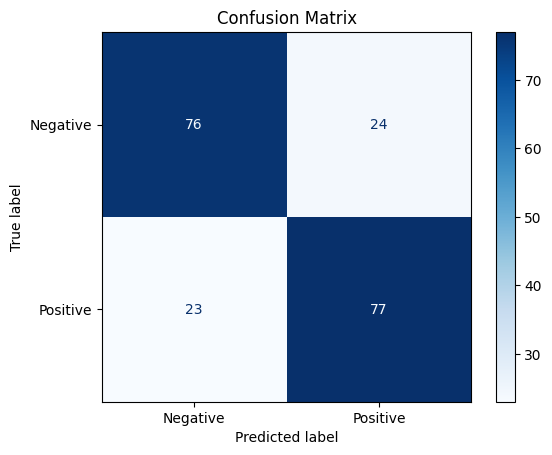

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Матрица ошибок
ConfusionMatrixDisplay.from_predictions(
    test_labels,
    test_preds,
    display_labels=['Negative', 'Positive'],
    cmap=plt.cm.Blues
)
plt.title('Confusion Matrix')
plt.show()

# Экспорт в ONNX

In [26]:
!pip install optimum onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 81.8 MB/s eta 0:00:00


In [27]:
!optimum-cli export onnx --model best_perceptron_model --task text-classification best_perceptron_onnx/

2025-06-17 16:10:19.539596: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750176619.616682   36739 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750176619.633981   36739 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_http.py", line 409, in hf_raise_for_status
    response.raise_for_status()
  File "/usr/local/lib/python3.11/dist-packages/requests/models.py", line 1024, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 401 Client Error: Unauthorized for url: https://huggingface.co/api/models/

### Шаг 1: Экспорт BERT модели

In [28]:
# export_bert.py
from transformers import BertModel, BertTokenizer
import torch

# Загрузка модели и токенизатора
model = BertModel.from_pretrained("bert-base-uncased")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model.eval()

# Создаем обертку для усреднения эмбеддингов
class BertForEmbeddings(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.bert = model

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden = outputs.last_hidden_state
        mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden.size()).float()
        sum_embeddings = torch.sum(last_hidden * mask_expanded, dim=1)
        sum_mask = torch.clamp(mask_expanded.sum(1), min=1e-9)
        return sum_embeddings / sum_mask

wrapped_model = BertForEmbeddings(model).eval()

# Экспорт в ONNX
dummy_inputs = {
    "input_ids": torch.randint(0, 10000, (1, 128), dtype=torch.long),
    "attention_mask": torch.ones((1, 128), dtype=torch.long)
}

torch.onnx.export(
    wrapped_model,
    (dummy_inputs["input_ids"], dummy_inputs["attention_mask"]),
    "bert_embeddings.onnx",
    input_names=["input_ids", "attention_mask"],
    output_names=["embeddings"],
    dynamic_axes={
        "input_ids": {0: "batch", 1: "sequence"},
        "attention_mask": {0: "batch", 1: "sequence"},
        "embeddings": {0: "batch"}
    },
    opset_version=17,
    do_constant_folding=True
)

# Сохраняем токенизатор
tokenizer.save_pretrained("bert_embeddings_onnx")
print("BERT модель успешно экспортирована")

BERT модель успешно экспортирована


### Шаг 2: Экспорт перцептрона

In [30]:
!pip install skl2onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 4.9 MB/s eta 0:00:00


In [31]:
# export_perceptron.py
import joblib
import numpy as np
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType
import onnx

# Загрузка сохраненной модели
model_data = joblib.load('best_perceptron_model.pkl')
perceptron = model_data['model']
scaler = model_data['scaler']

# Определяем тип входа
initial_type = [('float_input', FloatTensorType([None, 768]))]

# Конвертируем модель
onnx_model = convert_sklearn(
    perceptron,
    initial_types=initial_type,
    target_opset=17,
    options={'zipmap': False}  # Для классификатора
)

# Добавляем метаданные
onnx_model.doc_string = "Sentiment Analysis Perceptron"
onnx_model.producer_name = "Hugging Face Transformers.js"

# Сохраняем модель
onnx.save_model(onnx_model, "perceptron.onnx")

# Сохраняем параметры нормализации
scaler_params = {
    "mean": scaler.mean_.tolist(),
    "scale": scaler.scale_.tolist()
}

import json
with open("scaler_params.json", "w") as f:
    json.dump(scaler_params, f)

print("Перцептрон успешно экспортирован")

Перцептрон успешно экспортирован


### Шаг 3: Оптимизация моделей (опционально, но рекомендуется)

In [6]:
!pip install onnxruntime onnx

In [9]:
# Квантование BERT модели

!python -c "from onnxruntime.quantization import quantize_dynamic; quantize_dynamic('model.onnx', 'model_quantized.onnx')"

In [ ]:
# Квантование перцептрона

!python -m onnxruntime.quantization.quantize_dynamic \
  --input perceptron.onnx \
  --output perceptron_quantized.onnx

# Скачивание файлов моделей

## Дополнительно модели для корректной работы в onnx нужен файл tokenizer.json, который не сгенерировали изначально

In [38]:
from tokenizers import BertWordPieceTokenizer

# Создаём токенизатор в современном формате
tokenizer = BertWordPieceTokenizer.from_file("distilbert_embeddings_onnx/vocab.txt")

# Добавляем специальные токены
tokenizer.add_special_tokens([
    "[UNK]", "[SEP]", "[PAD]", "[CLS]", "[MASK]"
])

# Сохраняем в JSON формате
tokenizer.save("distilbert_embeddings_onnx/tokenizer.json")

In [37]:
from transformers import DistilBertTokenizer, DistilBertConfig, DistilBertModel
import transformers

# Загрузка модели и токенизатора
model_name = "distilbert-base-uncased"
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
model = DistilBertModel.from_pretrained(model_name)
config = DistilBertConfig.from_pretrained(model_name)

# Сохраняем файлы
output_dir = "distilbert_embeddings_onnx"
tokenizer.save_pretrained(output_dir)
model.save_pretrained(output_dir)
config.save_pretrained(output_dir)

print(f"Все файлы сохранены в {output_dir}")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Все файлы сохранены в distilbert_embeddings_onnx


## Сохранение файлов в папку models и скачивание

In [35]:
import os
import shutil
import numpy as np
import joblib

# Создаем структуру папок
os.makedirs("models/bert", exist_ok=True)
os.makedirs("models/perceptron", exist_ok=True)

# --- 1. Копируем BERT модель ---
shutil.copy("bert_embeddings.onnx", "models/bert_embeddings_onnx/bert_embeddings.onnx")

# --- 2. Копируем перцептрон и параметры ---
# Копируем ONNX модель перцептрона
shutil.copy("perceptron.onnx", "models/perceptron/model.onnx")

# Копируем квантованную версию (если есть)
if os.path.exists("perceptron_quant.onnx"):
    shutil.copy("perceptron_quant.onnx", "models/perceptron/model_quant.onnx")
else:
    # Если нет, создаем квантованную версию
    from onnxruntime.quantization import quantize_dynamic
    quantize_dynamic(
        "models/perceptron/model.onnx",
        "models/perceptron/model_quant.onnx"
    )

# --- 3. Копируем параметры нормализации ---
# Загрузка scaler из вашей модели
model_data = joblib.load('best_perceptron_model.pkl')
scaler = model_data['scaler']

# Сохраняем параметры нормализации
scaler_params = {
    "mean": scaler.mean_.tolist(),
    "scale": scaler.scale_.tolist()
}
with open("models/perceptron/scaler_params.json", "w") as f:
    json.dump(scaler_params, f)

# --- 4. Копируем эмбеддинги (для возможного дальнейшего использования) ---
os.makedirs("data", exist_ok=True)
shutil.copy("train_embeddings.npy", "data/train_embeddings.npy")
shutil.copy("test_embeddings.npy", "data/test_embeddings.npy")

print("Все файлы успешно скопированы!")

Все файлы успешно скопированы!


In [36]:
# Сожмите папку public в архив
!zip -r models.zip models/

# Скачайте архив
from google.colab import files
files.download('models.zip')

  adding: public/ (stored 0%)
  adding: public/models/ (stored 0%)
  adding: public/models/perceptron/ (stored 0%)
  adding: public/models/perceptron/model.onnx (deflated 22%)
  adding: public/models/perceptron/scaler_params.json (deflated 55%)
  adding: public/models/perceptron/model_quant.onnx (deflated 40%)
  adding: public/models/bert_embeddings_onnx/ (stored 0%)
  adding: public/models/bert_embeddings_onnx/vocab.txt (deflated 53%)
  adding: public/models/bert_embeddings_onnx/special_tokens_map.json (deflated 42%)
  adding: public/models/bert_embeddings_onnx/tokenizer_config.json (deflated 75%)
  adding: public/data/ (stored 0%)
  adding: public/data/train_embeddings.npy (deflated 7%)
  adding: public/data/test_embeddings.npy (deflated 7%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>